In [102]:
import numpy as np 
import tensorflow as tf 
import pandas as pd 
import json as js 
import os
import openpyxl as xl 
import itertools as it
import matplotlib.pyplot as plt
import random as rd
import seaborn as sb

In [2]:
def transform_strings(strings_list):

    result_STE_labels = strings_list
    allowed_simbols = "ЙЦУКЕНГШЩЗХЪФЫВАПРОЛДЖЭЯЧСМИТЬБЮйцукенгшщзхъфывапролджэячсмитьбюQWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm12345467890"

    for (label_number, STE_label) in enumerate(strings_list):

        tmp_STE_label = ""
        if (type(STE_label) != float):

            for simbol in STE_label:
                        
                if (simbol in allowed_simbols):
                    tmp_STE_label += simbol.lower()

                else:
                    tmp_STE_label += " "
                
            tmp_STE_list = tmp_STE_label.split()
            result_STE_list = []
            iterator = 0
            while iterator < len(tmp_STE_list):

                sub_string = tmp_STE_list[iterator]
                delete_condition = False
                if len(sub_string) >= 4:

                    for simbol in sub_string:

                        if (simbol in "1234567890"):

                            delete_condition = True
                            break

                    if not delete_condition:
                        result_STE_list.append(sub_string)
                
                iterator += 1
            
            result_STE_label = " ".join(sub_string for sub_string in result_STE_list)     
            result_STE_labels[label_number] = result_STE_label
                
        else:
            result_STE_labels[label_number] = STE_label
    
    return result_STE_labels

def sort_strings_list(strings_list):

    result_strings_list = []
    cn_collection = {}
    
    for string in strings_list:
        
        if (type(string) != float):

            tmp_string_list = string.split()
            curent_list_part = 1
            while curent_list_part < len(tmp_string_list):

                for sub_string_number in range(len(tmp_string_list) - curent_list_part):

                    if (tmp_string_list[sub_string_number] > tmp_string_list[sub_string_number + 1]):
                        
                        tmp_string_list[sub_string_number], tmp_string_list[sub_string_number + 1] = \
                        tmp_string_list[sub_string_number + 1], tmp_string_list[sub_string_number]

                curent_list_part += 1

            result_string = " ".join(sub_string for sub_string in tmp_string_list)
            result_strings_list.append(result_string)
            cn_collection[result_string] = string
        
        else:
            result_strings_list.append(string)
            cn_collection[string] = string
    
    return (result_strings_list, cn_collection)


def transform_single_string(string_to_transform):

    allowed_simbols = "ЙЦУКЕНГШЩЗХЪФЫВАПРОЛДЖЭЯЧСМИТЬБЮйцукенгшщзхъфывапролджэячсмитьбюQWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm12345467890"
    tmp_STE_label = ""
    if (type(string_to_transform) != float):

        for simbol in string_to_transform:
                        
            if (simbol in allowed_simbols):
                tmp_STE_label += simbol.lower()

            else:
                tmp_STE_label += " "
                
        tmp_STE_list = tmp_STE_label.split()
        result_STE_list = []
        iterator = 0
        while iterator < len(tmp_STE_list):

            sub_string = tmp_STE_list[iterator]
            delete_condition = False
            if len(sub_string) >= 4:

                for simbol in sub_string:

                    if (simbol in "1234567890"):

                        delete_condition = True
                        break

                if not delete_condition:
                    result_STE_list.append(sub_string)
                
            iterator += 1
        
        result_STE_label = " ".join(sub_string for sub_string in result_STE_list)
        return result_STE_label


def sort_single_string(string_to_sort):

    tmp_string_list = string_to_sort.split()
    curent_list_part = 1
    while curent_list_part < len(tmp_string_list):

        for sub_string_number in range(len(tmp_string_list) - curent_list_part):

            if (tmp_string_list[sub_string_number] > tmp_string_list[sub_string_number + 1]):
                        
                    tmp_string_list[sub_string_number], tmp_string_list[sub_string_number + 1] = \
                    tmp_string_list[sub_string_number + 1], tmp_string_list[sub_string_number]

            curent_list_part += 1

    result_string = " ".join(sub_string for sub_string in tmp_string_list)
    return (result_string, string_to_sort)


Консолидация данных

In [3]:


def collect_data_turnover(data_path):
    
    indexator = 1
    general_STE_labels = []
    data_collection = {
        "Оборотная ведомость сч. 105": {
            "квартал_1":{},
            "квартал_2": {},
            "квартал_3": {},
            "квартал_4": {}
        },
        "Оборотно-Сальдовая ведомость сч. 21": {
            "квартал_1":{},
            "квартал_2": {},
            "квартал_3": {},
            "квартал_4": {}
        },
        "Оборотно-Сальдовая ведомость сч. 101": {
            "квартал_1":{},
            "квартал_2": {},
            "квартал_3": {},
            "квартал_4": {}
        },
    }

    general_STE_labels = []
    for data_batch_f in os.listdir(data_path):
        
        if indexator > 4:
        
            general_STE_labels = []
            indexator = 1

        curent_batch_f = os.path.join(data_path, data_batch_f)
        curent_dataframe = pd.read_excel(curent_batch_f)

        if "сч. 105" in data_batch_f:

            report_type = "Оборотная ведомость " + "сч. 105"
            STE_labels = curent_dataframe["Наименование нефинансового актива"].to_list()
            STE_labels = transform_strings(STE_labels)
            STE_labels, _ = sort_strings_list(STE_labels)
            curent_dataframe["Наименование нефинансового актива"] = STE_labels
            curent_dataframe.columns = ["№ п/п", "Инвентарный номенклатурный номер", "Код справочника", "Наименование нефинансового актива",
                                       "Единица измерения", "Остаток на 1 января 2022 г.|дебет|кол-во", 
                                       "Остаток на 1 января 2022 г.|дебет|сумма", "Оборот за 1 квартал 2022 г.|дебет|кол-во", 
                                       "Оборот за 1 квартал 2022 г.|дебет|сумма", "Оборот за 1 квартал 2022 г.|кредит|кол-во", 
                                       "Оборот за 1 квартал 2022 г.|кредит|сумма", "Остаток на 31 марта 2022 г.|дебет|кол-во", 
                                       "Остаток на 31 марта 2022 г.|дебет|сумма"]
        
        elif ("сч. 101" in data_batch_f) or ("сч. 21"  in data_batch_f):

            report_type = "Оборотно-Сальдовая ведомость " + data_batch_f[data_batch_f.find("сч"): data_batch_f.find("за") - 1]
            STE_labels_index = curent_dataframe.columns[0]
            STE_labels = curent_dataframe[STE_labels_index].to_list()
            STE_labels = transform_strings(STE_labels)
            STE_labels, _ = sort_strings_list(STE_labels)
            curent_dataframe[STE_labels_index] = STE_labels

        general_STE_labels += STE_labels
        
        data_collection[report_type]["general_STE_labels"] = general_STE_labels
        data_collection[report_type][f"квартал_{indexator}"] = {
            "data": curent_dataframe,
            "STE_labels": STE_labels
        }
        general_STE_labels += STE_labels

        indexator += 1

    return data_collection

data_path = "C:\\Users\\1\\Desktop\\LDTProject\\dataset\\Обороты по счету"
data_collection = collect_data_turnover(data_path=data_path)
print(data_collection["Оборотно-Сальдовая ведомость сч. 101"]["квартал_1"].keys())

print(len(data_collection["Оборотная ведомость сч. 105"]["квартал_2"]["STE_labels"]))
print(len(data_collection["Оборотная ведомость сч. 105"]["квартал_3"]["STE_labels"]))
print(len(data_collection["Оборотная ведомость сч. 105"]["квартал_4"]["STE_labels"]))
# data_collection["Оборотная ведомость сч. 105"]["квартал_1"]["data"].iloc[:100].tail()
# data_collection["Оборотно-Сальдовая ведомость сч. 101"]["квартал_1"]["data"].iloc[:50].tail()
# data_collection["Оборотно-Сальдовая ведомость сч. 21"]["квартал_1"]["data"].iloc[:100].tail()





dict_keys(['data', 'STE_labels'])
212
209
260


Приведение таблицы ведомостей 101 и 21 к нормальному формату

In [4]:
for data_batch in data_collection.keys():

    if data_batch != "Оборотная ведомость сч. 105":

        curent_data_batch = data_collection[data_batch]
        for time_kvartal in curent_data_batch.keys():

            if time_kvartal != "general_STE_labels":

                curent_dataframe = curent_data_batch[time_kvartal]["data"]
                for column in curent_dataframe.columns:

                    if (column in ['ГОСУДАРСТВЕННОЕ КАЗЕННОЕ УЧРЕЖДЕНИЕ ГОРОДА МОСКВЫ "ИНФОРМАЦИОННЫЙ ГОРОД"', 
                        "Unnamed: 4", "Unnamed: 10", "Unnamed: 14", "Unnamed: 9", "Unnamed: 12"]) == False:
                        del curent_dataframe[column]

                curent_dataframe.columns = ["СТЕ", "Код", "Определитель", "Сальдо на начало периода|дебет", "Обороты за период|дебет", "Сальдо на конец периода|дебет"]
                amount_dataframe = curent_dataframe[curent_dataframe["Определитель"] == "Сумма"]
                count_dataframe = curent_dataframe[curent_dataframe["Определитель"] == "Кол."]

                del amount_dataframe["Определитель"]
                amount_dataframe.columns = ["СТЕ", "Код", "Сальдо на начало периода|дебет|сумма","Обороты за период|дебет|сумма", "Сальдо на конец периода|дебет|сумма"]
                
                del count_dataframe["Определитель"]
                count_dataframe.columns = ["СТЕ", "Код", "Сальдо на начало периода|дебет|кол.", "Обороты за период|дебет|кол.", "Сальдо на конец периода|дебет|кол."]
                count_dataframe["СТЕ"] = amount_dataframe["СТЕ"].to_list()
                count_dataframe["Код"] = amount_dataframe["Код"].to_list()


                
                data_collection[data_batch][time_kvartal]["data"] = [amount_dataframe, count_dataframe]




C:\Users\1\AppData\Local\Temp\ipykernel_10232\18395408.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_dataframe["СТЕ"] = amount_dataframe["СТЕ"].to_list()
C:\Users\1\AppData\Local\Temp\ipykernel_10232\18395408.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_dataframe["Код"] = amount_dataframe["Код"].to_list()


In [5]:
reminder_data_path = "C:\\Users\\1\\Desktop\\LDTProject\\dataset\\Складские остатки"
def collect_data_reminder(data_path):

    data_collection = {
        "Ведомость остатков (сч. 105)": {
            "31.03.2022": {},
            "30.06.2022": {},
            "30.09.2022": {},
            "31.12.2022": {}
        },
        "Ведомость остатков (сч. 101)": {
            "31.03.2022": {},
            "30.06.2022": {},
            "30.09.2022": {},
            "31.12.2022": {}
        },
        "Ведомость остатков (сч. 21)": {
            "31.03.2022": {},
            "30.06.2022": {},
            "30.09.2022": {},
            "31.12.2022": {}
        },
    }

    for reminder_sheet_f in os.listdir(data_path):
        
        curent_sample_f = os.path.join(data_path, reminder_sheet_f)
        curent_sample_df = pd.read_excel(curent_sample_f)

        if ("г." not in reminder_sheet_f):
            curent_sample_date = reminder_sheet_f[reminder_sheet_f.find("3"): reminder_sheet_f.find("(") - 1]

        else:
            curent_sample_date = reminder_sheet_f[reminder_sheet_f.find("3"): reminder_sheet_f.find("г.")]

        if "(сч. 105)" in reminder_sheet_f:
            
            report_type = "Ведомость остатков " + reminder_sheet_f[reminder_sheet_f.find("(сч."): reminder_sheet_f.find(")") + 1]
            STE_labels = curent_sample_df["МОЛ"].to_list()
            STE_labels = transform_strings(STE_labels)
            STE_labels, _ = sort_strings_list(STE_labels)
            curent_sample_df["МОЛ"] = STE_labels
            curent_sample_df.columns = ["Наименование нефинансового актива", "Цена", "Количество", "Сумма"]
        
        elif ("(сч. 21)" in reminder_sheet_f) or ("(сч. 101)" in reminder_sheet_f):
            
            
            report_type = "Ведомость остатков " + reminder_sheet_f[reminder_sheet_f.find("(сч."): reminder_sheet_f.find(")") + 1]
            "Ведомость остатков " + reminder_sheet_f[reminder_sheet_f.find("(сч."): reminder_sheet_f.find(")") + 1]

            for column in curent_sample_df.columns[3:-4]:
                
                del curent_sample_df[column]
            
            del curent_sample_df[curent_sample_df.columns[0]]
            del curent_sample_df[curent_sample_df.columns[0]]

            STE_labels = curent_sample_df[curent_sample_df.columns[0]].to_list()
            STE_labels = transform_strings(STE_labels)
            STE_labels, _ = sort_strings_list(STE_labels)
            
            curent_sample_df[curent_sample_df.columns[0]] = STE_labels
            #del curent_sample_df[curent_sample_df.columns[0]]
            curent_sample_df.columns = ["Наименование нефинансового актива", "Балансовая стоимость", "Количество", "Сумма амортизации", "Остаточная стоимость"]
        
        data_collection[report_type][curent_sample_date] = {
            "data": curent_sample_df,
            "STE_labels": STE_labels
        }
    
    return data_collection


reminder_data_collection = collect_data_reminder(data_path=reminder_data_path)
            

In [6]:
print(data_collection["Оборотная ведомость сч. 105"]["квартал_1"]["data"].shape[0])
print(reminder_data_collection["Ведомость остатков (сч. 105)"]["31.03.2022"]["data"].shape[0])


177
149


In [6]:
trade_inf_ph = "C:\\Users\\1\\Desktop\\LDTProject\\dataset\\Выгрузка контрактов по Заказчику.xlsx"
cll_path = "C:\\Users\\1\\Desktop\\LDTProject\\dataset\\КПГЗ ,СПГЗ, СТЕ.xlsx"
trade_inf_dataframe = pd.read_excel(trade_inf_ph)
cll_dataframe = pd.read_excel(cll_path)

Формирование информации о закупках пользователя за все время с файла "Выгрузка контрактов по заказчику"

In [229]:
STE_collection = []
cn_collection = {}

for ts_number in range(trade_inf_dataframe.shape[0]):

    trade_sample = trade_inf_dataframe.iloc[ts_number]
    cll_dataframe_batch = cll_dataframe[(cll_dataframe["Реестровый номер в РК"] == trade_sample["Реестровый номер в РК"])
                                    & (cll_dataframe["КПГЗ код"] == trade_sample["Конечный код КПГЗ"])
                                    & (cll_dataframe["КПГЗ"] == trade_sample["Конечное наименование КПГЗ"])]
    
    trade_sample_STE = cll_dataframe_batch["Название СТЕ"].to_list()
    trade_sample_STE = transform_strings(trade_sample_STE)
    trade_sample_STE, sub_cn_collection = sort_strings_list(trade_sample_STE)
    

    if len(trade_sample_STE) > 2:

        for variant in trade_sample_STE:

            STE_collection.append((variant, 
                                   trade_sample["Конечное наименование КПГЗ"],
                                   trade_sample["Конечный код КПГЗ"],
                                   trade_sample["Наименование СПГЗ"],
                                   trade_sample["ID СПГЗ"],
                                   sub_cn_collection[variant]))

    elif len(trade_sample_STE) == 1:
        STE_collection.append((trade_sample_STE[0], 
                               trade_sample["Конечное наименование КПГЗ"],
                               trade_sample["Конечный код КПГЗ"],
                               trade_sample["Наименование СПГЗ"],
                               trade_sample["ID СПГЗ"],
                               sub_cn_collection[trade_sample_STE[0]]))

print(STE_collection)
    

[('оказание охране помещений услуг', 'УСЛУГИ ЧАСТНОЙ ОХРАНЫ (ВЫСТАВЛЕНИЕ ПОСТА ОХРАНЫ)', '03.10.01.01', ' Услуги частной охраны (Выставление поста охраны)', 30173402.0, 'оказание услуг охране помещений'), ('охрана физическая', 'УСЛУГИ ЧАСТНОЙ ОХРАНЫ (ВЫСТАВЛЕНИЕ ПОСТА ОХРАНЫ)', '03.10.01.01', ' Услуги частной охраны (Выставление поста охраны)', 40196525.0, 'физическая охрана'), ('охрана физическая', 'УСЛУГИ ЧАСТНОЙ ОХРАНЫ (ВЫСТАВЛЕНИЕ ПОСТА ОХРАНЫ)', '03.10.01.01', ' Услуги частной охраны (Выставление поста охраны)', 40196525.0, 'физическая охрана'), ('officespace белый блок бокс записи пластиковый', 'БЛОКИ БУМАЖНЫЕ ДЛЯ ЗАПИСЕЙ', '01.15.01.07', 'Блоки для записей', 27354814.0, 'блок записи officespace пластиковый бокс белый'), ('staff блокнот вида гребень жесткая клетка подложка', 'БЛОКНОТЫ', '01.15.02.01', 'Блокнот', 44012513.0, 'блокнот гребень жесткая подложка клетка staff вида'), ('stenography блокнот картон клетка обложка офсет спираль', 'БЛОКНОТЫ', '01.15.02.01', 'Блокнот', 50147

In [8]:
general_STE_collection = []

for cll_cell in range(cll_dataframe.shape[0]):

    curent_trade_sample = cll_dataframe.iloc[cll_cell]
    STE_label = curent_trade_sample["Название СТЕ"]
    if type(STE_label) != float:

        STE_label = transform_single_string(STE_label)
        STE_label_sorted, STE_label = sort_single_string(STE_label)
        cll_type = curent_trade_sample["КПГЗ"]
        
        general_STE_collection.append((STE_label_sorted, cll_type, STE_label))

print(general_STE_collection)
    
    

[('чайник объем электрический электронное', 'ЭЛЕКТРОЧАЙНИКИ БЫТОВЫЕ', 'чайник электрический объем электронное'), ('delonghi ecam кофемашина емкость зерен объем капучинатор ручной черная', 'ЭЛЕКТРОКОФЕВАРКИ БЫТОВЫЕ', 'кофемашина delonghi ecam объем емкость зерен ручной капучинатор черная'), ('папка уголок', 'ПАПКИ ПЛАСТИКОВЫЕ', 'папка уголок'), ('кресло бюрократ офисное черное экокожа', 'КРЕСЛА ОФИСНЫЕ', 'кресло офисное бюрократ экокожа черное'), ('indesit общий объем морозильная камера холодильник дерево цвет', 'ХОЛОДИЛЬНИКИ БЫТОВЫЕ', 'холодильник indesit общий объем морозильная камера цвет дерево'), ('indesit общий объем верхняя морозильная камера белый холодильник', 'ХОЛОДИЛЬНИКИ БЫТОВЫЕ', 'холодильник indesit общий объем верхняя морозильная камера белый'), ('мебельный сейф valberg мебельный замок сейф', 'СЕЙФЫ ПРОЧИЕ', 'сейф мебельный сейф valberg мебельный замок'), ('офисный valberg сейф замок трейзер электронный', 'СЕЙФЫ ПРОЧИЕ', 'сейф офисный valberg электронный замок трейзер'), 

Формирование конечного набора данных в виде json словаря для пследующего анализа информации

In [234]:
#TODO дописать отбор парамтеров для обучения для отчетов типа сч 101 и сч 21


def combine_data_from_collections(STE_collection, json_file_path=None):
    
    found_reg_test = {}
    time_classification = {
        "квартал_1": "31.03.2022",
        "квартал_2": "30.06.2022",
        "квартал_3": "30.09.2022",
        "квартал_4": "31.12.2022"
    }

    batch_classification = {
        "Оборотная ведомость сч. 105": "Ведомость остатков (сч. 105)",
        "Оборотно-Сальдовая ведомость сч. 101": "Ведомость остатков (сч. 101)",
        "Оборотно-Сальдовая ведомость сч. 21": "Ведомость остатков (сч. 21)"
    }

    for trade_sample in STE_collection:

        found_reg_test[trade_sample[-1]] = {}
        for data_batch in data_collection.keys():

            reminder_report_type = batch_classification[data_batch]
            curent_data_batch = data_collection[data_batch]
            curent_data_batch_rem = reminder_data_collection[reminder_report_type]
            found_reg_test[trade_sample[-1]]["кварталы"] = {}

            for time_kvartal in data_collection[data_batch].keys():
                
                if time_kvartal != "general_STE_labels":
                    
                    inv_time_kvartal = time_classification[time_kvartal]
                    if data_batch == "Оборотная ведомость сч. 105":

                        curent_dataframe = curent_data_batch[time_kvartal]["data"]
                        curent_dataframe_rem = curent_data_batch_rem[inv_time_kvartal]["data"]
                    
                    else:

                        curent_dataframe_amount = curent_data_batch[time_kvartal]["data"][0]
                        curent_dataframe_count = curent_data_batch[time_kvartal]["data"][1]
                        curent_dataframe_rem = curent_data_batch_rem[inv_time_kvartal]["data"]
                

                    if data_batch == "Оборотная ведомость сч. 105":

                        amount_reg = {}
                        serched_dataframe = curent_dataframe[curent_dataframe["Наименование нефинансового актива"] == trade_sample[0]]
                        serched_dataframe_rem = curent_dataframe_rem[curent_dataframe_rem["Наименование нефинансового актива"] == trade_sample[0]]
                        if serched_dataframe.shape[0] != 0:
                            
                            start_amount = serched_dataframe["Остаток на 1 января 2022 г.|дебет|сумма"].to_numpy()[0]
                            start_count = serched_dataframe["Остаток на 1 января 2022 г.|дебет|кол-во"].to_numpy()[0]

                            if np.isnan(start_amount) == True or np.isnan(start_count) == True:
                                
                                start_amount = serched_dataframe["Оборот за 1 квартал 2022 г.|дебет|сумма"].to_numpy()[0]
                                start_count = serched_dataframe["Оборот за 1 квартал 2022 г.|дебет|кол-во"].to_numpy()[0]

                            amount_reg["начальная стоимость"] = start_amount
                            amount_reg["начальное кол-во"] = start_count
                            

                        if serched_dataframe_rem.shape[0] != 0:
                            
                            end_amount = serched_dataframe_rem["Сумма"].to_numpy()[0]
                            end_count = serched_dataframe_rem["Количество"].to_numpy()[0]

                            amount_reg["конечная стоимость"] = end_amount
                            amount_reg["конечное кол-во"] = end_count

                        if len(amount_reg) != 0:
                            
                            if len(trade_sample) == 3:

                                found_reg_test[trade_sample[2]]["Классификация"] = trade_sample[1]
                                found_reg_test[trade_sample[2]]["тип ведомости"] = data_batch
                                found_reg_test[trade_sample[2]]["кварталы"][time_kvartal] = amount_reg
                            
                            else:

                                found_reg_test[trade_sample[-1]]["Классификация КПГЗ"] = trade_sample[1]
                                found_reg_test[trade_sample[-1]]["Классификация СПГЗ"] = trade_sample[2]
                                found_reg_test[trade_sample[-1]]["ID СПГЗ"] = trade_sample[4]
                                found_reg_test[trade_sample[-1]]["тип ведомости"] = data_batch
                                found_reg_test[trade_sample[-1]]["кварталы"][time_kvartal] = amount_reg

                                
                    
                    else:
                        
                        amount_reg = {}
                        serched_dataframe_amount = curent_dataframe_amount[curent_dataframe_amount["СТЕ"] == trade_sample[0]]
                        serched_dataframe_count = curent_dataframe_count[curent_dataframe_count["СТЕ"] == trade_sample[0]]
                        serched_dataframe_rem = curent_dataframe_rem[curent_dataframe_rem["Наименование нефинансового актива"] == trade_sample[0]]
                        
                        if serched_dataframe_amount.shape[0] != 0:

                            start_amount = serched_dataframe_amount["Сальдо на начало периода|дебет|сумма"].to_numpy()[0]
                            start_count = serched_dataframe_count["Сальдо на начало периода|дебет|кол."].to_numpy()[0]

                            if np.isnan(start_amount) == True or np.isnan(start_count) == True:
                                
                                start_amount = serched_dataframe_amount["Обороты за период|дебет|сумма"].to_numpy()[0]
                                start_count = serched_dataframe_count["Обороты за период|дебет|кол."].to_numpy()[0]
                            
                            
                            amount_reg["начальная стоимость"] = start_amount
                            amount_reg["начальное кол-во"] = start_count
                        
                        if serched_dataframe_rem.shape[0] != 0:
                            
                            end_amount = serched_dataframe_rem["Балансовая стоимость"].to_numpy()[0]
                            end_count = serched_dataframe_rem["Количество"].to_numpy()[0]

                            amount_reg["конечная стоимость"] = end_amount
                            amount_reg["конечное кол-во"] = end_count
                        
                        if len(amount_reg) != 0:
                            
                            if len(trade_sample) == 3:

                                found_reg_test[trade_sample[2]]["Классификация"] = trade_sample[1]
                                found_reg_test[trade_sample[2]]["тип ведомости"] = data_batch
                                found_reg_test[trade_sample[2]]["кварталы"][time_kvartal] = amount_reg
                            
                            else:

                                found_reg_test[trade_sample[-1]]["Классификация КПГЗ"] = trade_sample[1]
                                found_reg_test[trade_sample[-1]]["Классификация СПГЗ"] = trade_sample[2]
                                found_reg_test[trade_sample[-1]]["ID СПГЗ"] = trade_sample[4]
                                found_reg_test[trade_sample[-1]]["тип ведомости"] = data_batch
                                found_reg_test[trade_sample[-1]]["кварталы"][time_kvartal] = amount_reg

    collection_without_empty = {}
    for trade_sample in found_reg_test.keys():

        if len(found_reg_test[trade_sample]["кварталы"]) != 0:
            collection_without_empty[trade_sample] = found_reg_test[trade_sample]
    
    collection_without_nan = {}
    for trade_sample in collection_without_empty.keys():

        curent_trade_sample = collection_without_empty[trade_sample]
        trade_sample_keys = [str(ts_key) for ts_key in curent_trade_sample.keys()]
        if "NaN" not in trade_sample_keys:

            collection_without_nan[trade_sample] = curent_trade_sample


    if json_file_path is not None:
        with open(json_file_path, "w") as json_file:

            js.dump(collection_without_nan, json_file)

    return collection_without_nan





In [235]:
combine_data_from_collections(STE_collection=STE_collection, 
                              json_file_path="C:\\Users\\1\\Desktop\\LDTProject\\trade_samples.json")

{'доска пробковая attache economy classic деревянная рамка': {'кварталы': {'квартал_4': {'начальная стоимость': 594.7,
    'начальное кол-во': 1}},
  'Классификация КПГЗ': 'ДОСКИ ИНФОРМАЦИОННЫЕ',
  'Классификация СПГЗ': '01.15.05.03.01.04',
  'ID СПГЗ': 179212367.0,
  'тип ведомости': 'Оборотно-Сальдовая ведомость сч. 101'},
 'холодильник indesit общий объем морозильная камера цвет дерево': {'кварталы': {'квартал_1': {'начальная стоимость': 37026,
    'начальное кол-во': 3,
    'конечная стоимость': 12342,
    'конечное кол-во': 1},
   'квартал_2': {'начальная стоимость': 37026,
    'начальное кол-во': 3,
    'конечная стоимость': 12342,
    'конечное кол-во': 1},
   'квартал_3': {'начальная стоимость': 37026,
    'начальное кол-во': 3,
    'конечная стоимость': 12342,
    'конечное кол-во': 1},
   'квартал_4': {'начальная стоимость': 37026,
    'начальное кол-во': 3,
    'конечная стоимость': 12342,
    'конечное кол-во': 1}},
  'Классификация КПГЗ': 'ХОЛОДИЛЬНИКИ БЫТОВЫЕ',
  'Классиф

In [236]:
combine_data_from_collections(STE_collection=general_STE_collection,
                              json_file_path="C:\\Users\\1\\Desktop\\LDTProject\\general_samples.json")

{'доска магнитно маркерная': {'кварталы': {'квартал_1': {'начальная стоимость': 16000,
    'начальное кол-во': 1,
    'конечная стоимость': 16000,
    'конечное кол-во': 1},
   'квартал_2': {'начальная стоимость': 16000,
    'начальное кол-во': 1,
    'конечная стоимость': 16000,
    'конечное кол-во': 1},
   'квартал_3': {'начальная стоимость': 16000,
    'начальное кол-во': 1,
    'конечная стоимость': 16000,
    'конечное кол-во': 1},
   'квартал_4': {'начальная стоимость': 16000,
    'начальное кол-во': 1,
    'конечная стоимость': 16000,
    'конечное кол-во': 1}},
  'Классификация': 'ДОСКИ МАГНИТНО-МАРКЕРНЫЕ',
  'тип ведомости': 'Оборотно-Сальдовая ведомость сч. 101'},
 'холодильник атлант': {'кварталы': {'квартал_1': {'начальная стоимость': 15000,
    'начальное кол-во': 1,
    'конечная стоимость': 15000,
    'конечное кол-во': 1},
   'квартал_2': {'начальная стоимость': 15000,
    'начальное кол-во': 1,
    'конечная стоимость': 15000,
    'конечное кол-во': 1},
   'квартал_3'

In [237]:
with open("C:\\Users\\1\\Desktop\\LDTProject\\trade_samples.json", "r") as json_file:
    result_reg_collection = js.load(json_file)

with open("C:\\Users\\1\\Desktop\\LDTProject\\general_samples.json", "r") as json_file:
    general_reg_collection = js.load(json_file)

Анализ и обработка данных

In [18]:
def formulate_data(trade_collection, final_type):

    all_types = [trade_collection[trade_sample]["Классификация СПГЗ"] for trade_sample in trade_collection.keys()]
    likvid_collection = {}
    for cll_type in all_types:

        likvid_collection[cll_type] = {}

        for trade_sample in trade_collection.keys():

            ts_curent = trade_collection[trade_sample]
            curent_sample = trade_collection[trade_sample]["кварталы"]
            likvid_collection[cll_type][trade_sample] = {}
            likvid_collection[cll_type]["Классификация КПГЗ"]

            for time_kvartal in curent_sample.keys():

                kvartal_reg = curent_sample[time_kvartal]
                kvartal_reg_keys = [reg_key for reg_key in kvartal_reg.keys()]

                if cll_type == ts_curent["Классификация"]:
                    
                    if ("конечная стоимость" in kvartal_reg_keys) and ("конечное кол-во" in kvartal_reg_keys):

                        likvid_collection[cll_type][trade_sample][time_kvartal] = kvartal_reg


    collection_without_empty = {}
    for cll_sample in likvid_collection.keys():

        curent_cll_sample = likvid_collection[cll_sample]
        collection_without_empty[cll_sample] = {}
        for trade_sample in curent_cll_sample.keys():

            if len(curent_cll_sample[trade_sample]) != 0:

                collection_without_empty[cll_sample][trade_sample] = curent_cll_sample[trade_sample]



    collection_without_duplicates = {}
    deprecated_keys = []
    for cll_cell in collection_without_empty.keys():

        curent_cell = collection_without_empty[cll_cell]
        collection_without_duplicates[cll_cell] = {}

        for trade_sample in curent_cell.keys():

            if trade_sample not in deprecated_keys:

                collection_without_duplicates[cll_cell][trade_sample] = curent_cell[trade_sample]
                deprecated_keys.append(trade_sample)
            
    return collection_without_duplicates

need_collection = formulate_data(trade_collection=result_reg_collection)
need_general_collection = formulate_data(trade_collection=general_reg_collection)

with open("C:\\Users\\1\\Desktop\\LDTProject\\result_cll_collection.json", "w") as json_file:
    js.dump(need_collection, json_file)

with open("C:\\Users\\1\\Desktop\\LDTProject\\general_cll_collection.json", "w") as json_file:
    js.dump(need_general_collection, json_file)


                

Формирование набора данных для оубчения регрессивной модели 

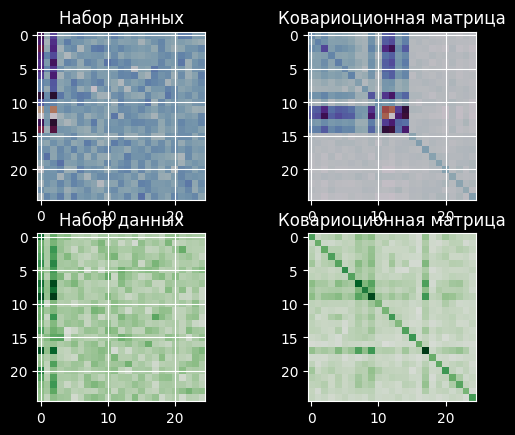

In [208]:
def generate_dataset(trade_collection, need_data_shape, time_kvartal, test_data=False):

    time_kvartals = {
        "квартал_1": 0,
        "квартал_2": 1,
        "квартал_3": 2,
        "квартал_4": 3 
    }
    dataset_tensor = np.zeros(need_data_shape)
    curent_data_tensor = []
    dataset_labels = []
    curent_sample_number = 0
    for cll_cell_id in trade_collection.keys():

        curent_cll_cell = trade_collection[cll_cell_id]
        for trade_sample in curent_cll_cell.keys():

            
            features = [[float(curent_cll_cell[trade_sample][time_kvartal][feature]) 
                       for feature in curent_cll_cell[trade_sample][time_kvartal].keys()]
                       for time_kvartal in curent_cll_cell[trade_sample].keys()]
            
            if time_kvartal == "all":
                
                dataset_labels.append(trade_sample)
                feature_tensor = np.asarray(features)
                feature_tensor = np.asarray([np.mean(feature_tensor[:, col_number]) for col_number in range(feature_tensor.shape[1])])
                curent_data_tensor.append(feature_tensor)
            
            else:
                
                if time_kvartals[time_kvartal] < len(features):
                    
                    dataset_labels.append(trade_sample)
                    feature_tensor = features[time_kvartals[time_kvartal]]
                    curent_data_tensor.append(feature_tensor)

            curent_sample_number += 1
    
    

    if (need_data_shape[0] < dataset_tensor.shape[0]) or (need_data_shape[1] < dataset_tensor.shape[1]):

        raise BaseException("dimention that was choosed less then dataset_tensor")

    else:
        
       
        curent_data_tensor = np.asarray(curent_data_tensor)
        if test_data:
            dataset_tensor = np.resize(dataset_tensor, (curent_data_tensor.shape[0], need_data_shape[1]))
        dataset_tensor[:curent_data_tensor.shape[0], :curent_data_tensor.shape[1]] = curent_data_tensor
        dataset_tensor_std = (dataset_tensor - np.mean(dataset_tensor)) / np.std(dataset_tensor)
        dataset_tensor_std += np.random.normal(0.12, 1.67, dataset_tensor.shape)
        
        


    return (dataset_tensor_std, dataset_labels)
    
    

plt.style.use("dark_background")
train_dataset_tensor, train_dataset_ste = generate_dataset(trade_collection=need_general_collection, need_data_shape=(100, 100), time_kvartal="квартал_1")
test_dataset_tensor, test_dataset_ste = generate_dataset(trade_collection=need_collection, need_data_shape=(100, 100), time_kvartal="квартал_1", test_data=True)
train_dataset_covar = np.cov(train_dataset_tensor)
test_dataset_covar = np.cov(test_dataset_tensor)
test_dataset_labels = ((test_dataset_tensor[:, 0] * 50.0) / 100.0) - ((test_dataset_tensor[:, 2] * 50.0) / 100.0)
train_dataset_labels = ((train_dataset_tensor[:, 0] * 50.0) / 100.0) - ((train_dataset_tensor[:, 2] * 50.0) / 100.0)


fig, axis = plt.subplots(nrows=2, ncols=2)
axis[0, 0].imshow(train_dataset_tensor[:25, 0:25], cmap="twilight", label="набора данных", alpha=0.88)
axis[0, 1].imshow(train_dataset_covar[:25, :25], cmap="twilight", label="ковариоционная матрица", alpha=0.88)
axis[1, 0].imshow(test_dataset_tensor[:25, 0:25], cmap="Greens", label="набора данных", alpha=0.88)
axis[1, 1].imshow(test_dataset_covar[:25, :25], cmap="Greens", label="ковариоционная матрица", alpha=0.88)
axis[0, 0].set_title("Набор данных")
axis[0, 1].set_title("Ковариоционная матрица")
axis[1, 0].set_title("Набор данных")
axis[1, 1].set_title("Ковариоционная матрица")
axis[0, 0].grid(True)
axis[0, 1].grid(True)
axis[1, 0].grid(True)
axis[0, 1].grid(True)

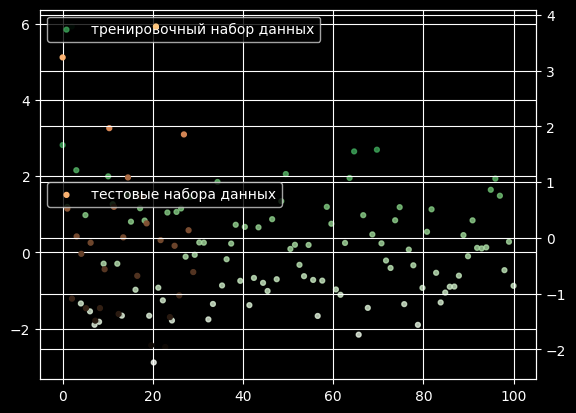

In [209]:
fig, axis = plt.subplots()
axis.scatter(np.linspace(0, train_dataset_labels.shape[0], train_dataset_labels.shape[0]), 
                train_dataset_labels, c=train_dataset_labels, cmap="Greens", 
                s=12.12, alpha=0.78, label="тренировочный набор данных")
axis_1 = axis.twinx()
axis_1.scatter(np.linspace(0, test_dataset_labels.shape[0], test_dataset_labels.shape[0]), 
                test_dataset_labels, c=test_dataset_labels, cmap="copper", 
                s=12.12, alpha=0.98, label="тестовые набора данных")


axis.grid(True)
axis_1.grid(True)
axis.legend(loc="upper left")
axis_1.legend(loc="center left")
plt.show()

Между данными соблюдена нормальная корреляция

In [120]:
def build_reg_model(need_feature_shape):

    input_tensor = tf.keras.Input(shape=(need_feature_shape, ))

    model_layer = tf.keras.layers.Dense(120, activation="relu")(input_tensor)
    model_layer = tf.keras.layers.Dense(64, activation="relu")(model_layer)
    model_layer = tf.keras.layers.Dense(32, activation="relu")(model_layer)
    model_layer = tf.keras.layers.Dense(1, activation="linear")(model_layer)

    model = tf.keras.Model(input_tensor, model_layer)
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

    return model
    

In [210]:
regression_model = build_reg_model(need_feature_shape=train_dataset_tensor.shape[1])
reg_model_history = regression_model.fit(train_dataset_tensor, train_dataset_labels,
                                           epochs=100,
                                           batch_size=60)

<class 'keras.src.models.functional.Functional'>
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8866 - mean_absolute_error: 1.4681  
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5822 - mean_absolute_error: 0.9629 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9270 - mean_absolute_error: 0.6798 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4794 - mean_absolute_error: 0.4934 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3808 - mean_absolute_error: 0.4379 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2412 - mean_absolute_error: 0.3177 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1219 - mean_absolute_error: 0.2192 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0793 - mean_absolute_error: 0.1703 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0545 - mean_absolute_error: 0.1383 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0349 - mean_absolute_error: 0.1151 

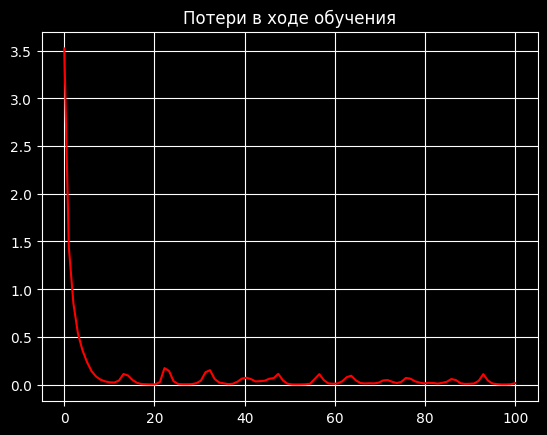

In [211]:
fig, axis = plt.subplots()
axis.plot(np.linspace(0, len(reg_model_history.history["loss"]), len(reg_model_history.history["loss"])),
          reg_model_history.history["loss"], color="red")
axis.set_title("Потери в ходе обучения")
axis.grid(True)

In [225]:
def max_likvid_samples(data_to_analize):

    model_predictions = regression_model.predict(data_to_analize[0])
    model_predictions = np.resize(model_predictions, (model_predictions.shape[0], ))
    deprecated_list = []
    
    while len(deprecated_list) < 3:
        
        max_value = 0
        max_sample = None
        for (sample_number, sample) in enumerate(data_to_analize[1]):

            if (model_predictions[sample_number] > max_value) and (sample not in deprecated_list):
                
                max_value = model_predictions[sample_number]
                max_sample = data_to_analize[1][sample_number]

        deprecated_list.append(max_sample)
    
    return deprecated_list


data_to_analize = (test_dataset_tensor, test_dataset_ste)
max_likvid_val = max_likvid_samples(data_to_analize)
print(max_likvid_val)


        
        


    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
['диван эволюшн модуль местный экокожа черный', 'сейф мебельный valberg электронный замок', 'кресло алекто экокожа графит']


In [ ]:
def generate_final_json(samples):

    final_json = {
        "id": "None",
        "LotEntityId": "None",
        "CostumerId": "None",
        "СПГЗ": {},
    }

    for sample in samples:

        cll_dataframe_serched = 

In [216]:
def show_stat(data_to_analize, graph_type):

    model_predictions = regression_model.predict(data_to_analize[0])
    model_predictions = np.resize(model_predictions, (model_predictions.shape[0], ))
    
    plt.style.use("dark_background")
    fig, axis = plt.subplots()

    if graph_type == "hist":
        
        print(len(data_to_analize[1]), model_predictions.shape)
        axis.hist(model_predictions, bins=len(data_to_analize[1]), color="orange")
        axis.set_xticklabels(data_to_analize[1])
        axis.grid(True)

        plt.xticks(rotation=60, ha='right')
        plt.show()
    
    elif graph_type == "heatmap":
        
        columns = []
        heatmap = np.zeros((len(data_to_analize[1]), model_predictions.shape[0]))
        for (row_number, ste_label) in enumerate(data_to_analize[1]):
            for (col_number, prediction) in enumerate(model_predictions):
                
                if row_number == col_number:
                    heatmap[row_number, col_number] = prediction
                    columns.append(f"Prediction_{row_number}")
                    
        heatmap_df = pd.DataFrame(data=heatmap,
                                  index=data_to_analize[1],
                                  columns=columns)
        sb.heatmap(heatmap_df, cmap="magma", linewidth=.5)
    
    elif graph_type == "corr":
        
        corr_heatmap = np.cov(data_to_analize[0])
        corr_heatmap_df = pd.DataFrame(data=corr_heatmap,
                                       index=data_to_analize[1],
                                       columns=data_to_analize[1])
        sb.heatmap(corr_heatmap_df, linewidth=.5)
    





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


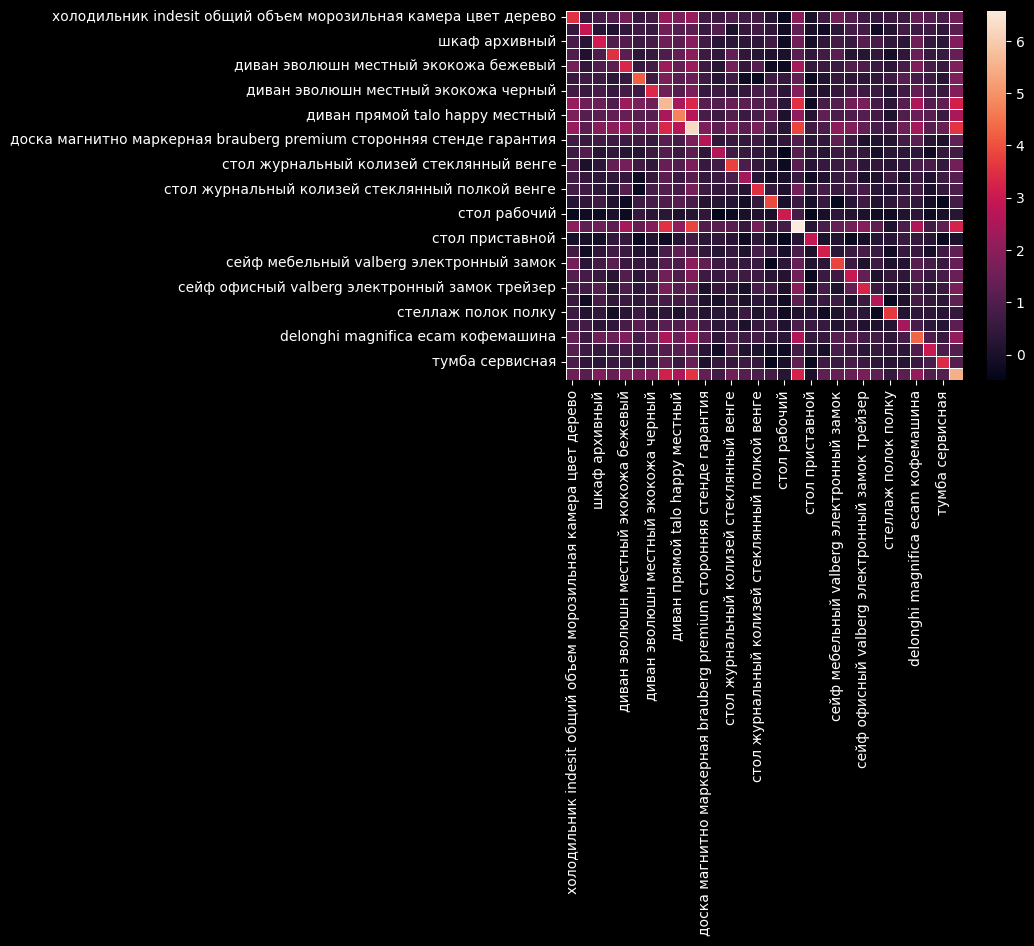

In [217]:
data_to_analize = (test_dataset_tensor, test_dataset_ste)
show_stat(data_to_analize, graph_type="corr")

In [ ]:
def formulate_final_json():
    